# Data Science Case Study: <br> Bay Area Rapid Transit's "Excursion Fare"


"BART’s Excursion Fare allows anyone to tour the BART system (all 44 stations) for up to three hours on a $5.75 fare,
as long as you enter and exit at the same station." - excerpt from Bart Guide @ http://www.bart.gov/guide

Depending on your level of experience using BART, this may or may not sound like an attractive option. I personally have incurred the excursion fee only by accident, on one or two occasions whereupon entering the station, I realized I had to go back to home or work or decided to use an alternative transportation. 

I started this data project to answer a very basic question: <br>

*** Are 'excursions' a random manifestation of mistakes by BART users like myself, or are users intentionally electing to use the BART system in this way? *** <br>

Not knowing anyone from the latter case personally, I hope to answer this by inferring individual behavior from publicly-available aggregated BART ridership data. I also will to employ some skills I'm developing in data engineering/science, along with statistical/timeseries/data analysis.

The main steps of the project will address the following, the first of which is tackled on this post:

1. Is excursion data randomly distributed?
* If it's not, are patterns to trips such as these?
* What explanations are possible of these patterns?
* What would I learn by sharing my research with others? 

# Source

Bart is outstanding in its dedication to sharing data through its API and ridership reports http://64.111.127.166/ridership/
<br>I used the ridership files that summarized every hour of every station's rides between the years 2011-2015

An example of one of the files is ***date-hour-soo-dest-2011.csv.gz***<br>

As suggested in its filename, it contains a csv summarizing passenger totals identified by the unique combination of date, hour, station of origin, and destination. Its decompressed size is approx 234 MB, containing 9M+ rows of comma separated values.




# Data Storage 

To make the data more friendly for some of the transformations and analyses required later, I previously extracted/transformed it into a python dictionary of Pandas DataFrames. That collection is stored as a pickle object, (size of 516MB*), so loading takes a couple minutes:

In [2]:
import pandas as pd
dfs = pd.read_pickle('../bart/data/combos_2011.pkl')

**Why so large? The file is much larger than that of the sample data used here so that analyses can be repeated on other stations.*

There are 1936 (44 x 44) unique trips possible, given origins and destinations from this station list: 

In [3]:
sta = ['16TH', '24TH', 'ASHB', 'BAYF', 'CIVC', 'COLS', 'CONC', 'DALY',
       'DBRK', 'EMBR', 'FRMT', 'FTVL', 'HAYW', 'MCAR', 'MLBR', 'MONT',
       'NBRK', 'PHIL', 'PITT', 'PLZA', 'POWL', 'ROCK', 'SANL', 'WCRK',
       'WOAK', 'BALB', 'DELN', 'GLEN', 'LAFY', 'RICH', 'UCTY', '19TH',
       'CAST', 'LAKE', 'SFIA', 'SHAY', 'DUBL', 'COLM', 'NCON', 'ORIN',
       '12TH', 'SBRN', 'SSAN', 'WDUB']

print 'Total Stations :', len(sta)
print 'Total DataFrames: ', len(dfs)

Total Stations : 44
Total DataFrames:  1936


Each DataFrame in the dictionary **dfs** has a key corresponding to one of these unique trips, in the form of a tuple:<br>

*(station of origin, destination)*<br>

For example, the trips from West Oakland to Balboa Park are in the first DataFrame.

In [4]:
print 'First key :', dfs.keys()[0]

First key : ('WOAK', 'BALB')


The DataFrame with this key is Period-Indexed hourly and its sole column **'pass'** represents the number of passengers that had entered at some previous time to WOAK, and exited BALB during the indexed hour.

For example, on New Year's Eve, in the hour between 23:00 and midnight, 5 passengers exited at Balboa Park who had entered the system at West Oakland.

In [5]:
print dfs[('WOAK', 'BALB')].tail()

                  pass
2011-12-31 19:00     1
2011-12-31 20:00     1
2011-12-31 21:00     1
2011-12-31 22:00     2
2011-12-31 23:00     5


I used data combined from this DataFrame and all others starting originating from West Oakland by using the iterator of keys:

In [6]:
woak_keys = filter(lambda (soo, dest): soo == 'WOAK', dfs.iterkeys())
print woak_keys

[('WOAK', 'BALB'), ('WOAK', 'DBRK'), ('WOAK', 'ORIN'), ('WOAK', 'HAYW'), ('WOAK', 'SSAN'), ('WOAK', 'FTVL'), ('WOAK', 'SANL'), ('WOAK', 'DUBL'), ('WOAK', '12TH'), ('WOAK', 'COLS'), ('WOAK', 'MCAR'), ('WOAK', 'RICH'), ('WOAK', 'LAKE'), ('WOAK', 'WOAK'), ('WOAK', 'FRMT'), ('WOAK', 'COLM'), ('WOAK', 'MONT'), ('WOAK', 'POWL'), ('WOAK', 'CIVC'), ('WOAK', 'PLZA'), ('WOAK', 'CONC'), ('WOAK', '19TH'), ('WOAK', 'SHAY'), ('WOAK', 'ROCK'), ('WOAK', 'SBRN'), ('WOAK', 'UCTY'), ('WOAK', 'PHIL'), ('WOAK', 'WDUB'), ('WOAK', '24TH'), ('WOAK', 'DELN'), ('WOAK', 'PITT'), ('WOAK', 'SFIA'), ('WOAK', 'NCON'), ('WOAK', 'EMBR'), ('WOAK', '16TH'), ('WOAK', 'DALY'), ('WOAK', 'CAST'), ('WOAK', 'BAYF'), ('WOAK', 'MLBR'), ('WOAK', 'LAFY'), ('WOAK', 'ASHB'), ('WOAK', 'NBRK'), ('WOAK', 'WCRK'), ('WOAK', 'GLEN')]


I collected all the DataFrames corresponding to these keys into a smaller dictionary, and mashed them all together column-wise to make a single DataFrame representing every trip over every hour of 2011 that has WOAK as the station of origin.

In [7]:
woak_dict = {key[1] : dfs[key] for key in woak_keys}
woak_df = pd.concat(woak_dict, axis = 1)
# drop previous column name 'pass'
woak_df.columns = woak_df.columns.droplevel(1)

The new DataFrame **woak_df** now has 44 columns, each identified by the station code of the destination. 

In [8]:
print woak_df.tail()

                  12TH  16TH  19TH  24TH  ASHB  BALB  BAYF  CAST  CIVC  COLM  \
2011-12-31 19:00     8    24     1    15     2     1     2     0    38     0   
2011-12-31 20:00     2    19     3    13     0     1     0     0    41     0   
2011-12-31 21:00     5    19     3    17     2     1     2     0    38     0   
2011-12-31 22:00     1    33     9    14     0     2     0     0    38     0   
2011-12-31 23:00     0    28     0     7     3     5     1     0    38     0   

                  ...   ROCK  SANL  SBRN  SFIA  SHAY  SSAN  UCTY  WCRK  WDUB  \
2011-12-31 19:00  ...      0     1     0     2     0     1     1     0     0   
2011-12-31 20:00  ...      0     0     2     1     1     1     0     0     0   
2011-12-31 21:00  ...      0     2     0     0     0     1     0     0     0   
2011-12-31 22:00  ...      0     1     0     1     1     0     0     0     0   
2011-12-31 23:00  ...      0     0     0     0     2     0     0     0     0   

                  WOAK  
2011-12-31 19

Note above that the final column is WOAK itself. This column's values represent the count of 'excursions' that entered and exited West Oakland!

# Exploratory Data Analysis Caveats

For each destination column of our DataFrame, relevant summary statistics are listed below: 

In [9]:
print woak_df.describe()

              12TH         16TH         19TH         24TH         ASHB  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean      3.457534     7.123744     2.281050     5.327854     1.420320   
std       5.902625     7.424298     3.213314     5.768455     2.733728   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000     0.000000     1.000000     0.000000   
50%       2.000000     6.000000     1.000000     4.000000     1.000000   
75%       5.000000    11.000000     4.000000     8.000000     2.000000   
max     288.000000   128.000000   109.000000   170.000000   108.000000   

             BALB         BAYF         CAST         CIVC         COLM  \
count  8760.00000  8760.000000  8760.000000  8760.000000  8760.000000   
mean      2.63242     1.698174     0.336758    17.464384     0.440411   
std       3.52834     1.975127     0.669714    21.311232     0.793777   
min       0.00000     0.000000     0.0000

Some general notes:
* There are 8760 values in each column, since there are 24 hours x 365 days in 2011.<br>
* Judging by many of the 50th percentile statistics there is an abundance of values equal to 0.<br> 
* Many of these zeros were filled into the original data to give the continuous hourly Period-Indexing desired for easy dataframe merging.

Some possible ramifications of the zero-filling that I considered:
1. This might be a bad inference, for example on days OCT15-16 where there was no data for the station. 
2. BART is typically closed for a few hours each morning. While 0s are a good inference, they have the same implication as no business on open hours.
3. Statistics based on hourly rates may be unfair representations, or may be misinterpreted.

# An interesting observation

Consider the two trips I've specifically mentioned thus far: *(WOAK,BALB) and (WOAK,WOAK)*<br>

The mean amount of trips per hour to Balboa Park is 2.63, while the mean amount of Excursions per hour is much lower at 0.47.

In [10]:
print woak_df[['BALB', 'WOAK']].mean()

BALB    2.63242
WOAK    0.47363
dtype: float64


However, the maximum observed trips for each of these routes is surprisingly similar:

In [11]:
print woak_df[['BALB', 'WOAK']].max()  

BALB    34
WOAK    36
dtype: int64


This is an example of the sort of peculiar looking data that motivated me to dig deeper into the excursion data and evaluate if anomalies like this are statistically significant.<br>*Is it reasonable to assume that the count of excursions in an hour might be 36 when it's typically 0 or 1 for a given hour?*

# Big Picture

Though I was motivated by single peculiar observations, I wanted to have the full picture by considering all of the data in aggregation.<br> No better way to do this than visualizing it.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The first thing I wanted to know is: does the data for WOAK excursions look random?

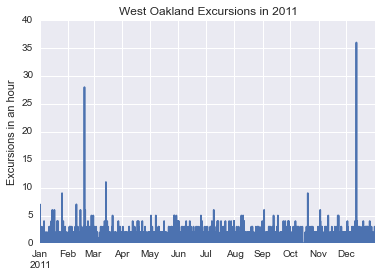

In [13]:
excursions = woak_df['WOAK']
excursions.plot()
plt.title('West Oakland Excursions in 2011'), plt.ylabel('Excursions in an hour')
plt.show()

The data from the barchart appears to random, except for a couple observations that are obvious outliers.<br>Distribution of these total counts are binned below and visualized in the the following histogram: 

In [14]:
binned = excursions.value_counts().sort_index()
binned

0     5950
1     1936
2      617
3      174
4       48
5       16
6       10
7        2
8        1
9        2
10       1
11       1
28       1
36       1
Name: WOAK, dtype: int64

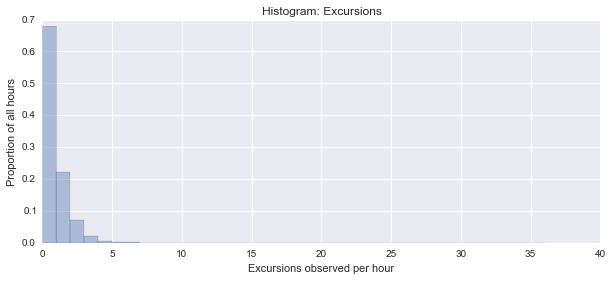

In [15]:
plt.figure(figsize=(10,4))
sns.distplot(excursions, kde = False, norm_hist= True, bins = excursions.max()) 
plt.title('Histogram: Excursions'), plt.xlabel('Excursions observed per hour'), plt.ylabel('Proportion of all hours')
plt.show()

Not only did outliers evidence themselves on the barchart, but they also look very out of place on the binned table, and they positively ruin the histogram's proportionality aesthetics! I'm convinced the data at this one station is already telling me that it's not random, but I want to statistically prove it.

# How random?

To answer this, I defined the probability of an excursion from West Oakland being = sum of all excursions/sum of all entries to the station.<br> The interpretation is: given you entered the station, what's the chance that you exit it as well?

In [16]:
all_by_hr = woak_df.sum(axis = 1)
p_excursion = excursions.sum()/float(all_by_hr.sum())
p_excursion

0.0024811462189879147

I made the assumption that any given person who enters the station has this roughly quarter-percent chance of exiting it as well, and their chance is not dependent on anything else or anyone else (is independently and identically distributed).<br>

The expectation values for amount of excursions, given the orignal total hourly trips data, would be:

In [17]:
E_excursions = (p_excursion * all_by_hr).round().astype('int')
E_excursions.value_counts()

0    5430
1    2672
2     550
3     106
4       2
dtype: int64

By expectation values alone, the highest is 4 excursions in one hour.<br>
Try not to get too excited by this, because it's more of a benchmark for what to expect, not necessarily an estimation of what it could be.

In [18]:
busiest_hour = all_by_hr.argmax()
print 'Peak entries occurred at :', busiest_hour
print 'Total entries to WOAK during this hour :', woak_df.ix[busiest_hour].sum()
print 'Expected value of excursions this hour : ', p_excursion * all_by_hr[busiest_hour]
print 'Total observed excursions in this hour : ', woak_df.ix[busiest_hour, 'WOAK']

Peak entries occurred at : 2011-11-02 19:00
Total entries to WOAK during this hour : 1651
Expected value of excursions this hour :  4.09637240755
Total observed excursions in this hour :  0


So the busiest hour overall for the year actually had *zero* excursions occur. Given that there were 1651 entries, what's the likelihood that it would be exactly 0? Using the binomial probability mass function with p = 0.00248 of success, n = 1651 chances, and k = 0 successes:


$$binom.pmf(k) = choose(n, k) * p^k * (1-p)^(n-k)$$

In [19]:
import scipy.stats as scs
scs.binom.pmf(n = 1651, k = 0, p = p_excursion)

0.016548452624289521

There was a 1.65% chance of that occurring, which isn't anything to scream about, but what about our outlier values, like 36?

In [20]:
unusual_hour = excursions.argmax()
print 'Unusual excursions occurred at :', unusual_hour
print 'Total entries to WOAK during this hour : ', woak_df.ix[unusual_hour].sum()
print 'Expected value of excursions this hour : ', p_excursion * all_by_hr[unusual_hour]
print 'Total observed excursions in this hour : ', woak_df.ix[unusual_hour, 'WOAK']

Unusual excursions occurred at : 2011-12-12 05:00
Total entries to WOAK during this hour :  192
Expected value of excursions this hour :  0.476380074046
Total observed excursions in this hour :  36


I crunched the probability on this observation below, using the survival function + the discrete probability from the probability mass function. Interpret this as the probability of seeing 36 or anything higher.

In [21]:
prob_36 = scs.binom.pmf(n = 192, k = 36, p = p_excursion)
prob_37andup = scs.binom.sf(n = 192, k = 36, p = p_excursion)
prob_36andup = prob_37andup + prob_36
print prob_36andup

1.41274037684e-55


I believe way to evaluate this probability is to say, "Given the null hypothesis that the random binomial variables are i.i.d., an observation of 36 or higher is... ". Yeah, just not gonna happen. We'd reject the null hypothesis based on this observation.

# What would random look like?

To do this, I ran a simulation of random binomial variables with the assumed probability of excursion, with the total hourly data from 2011 as an input.

In [22]:
# Simulate binomial random variables for every hour of 2011:
sim_excursions = scs.binom(n = all_by_hr, p = p_excursion).rvs()
binned_sims = pd.Series(sim_excursions).value_counts()
binned_sims

0    6069
1    1775
2     593
3     208
4      66
5      35
6       8
7       6
dtype: int64

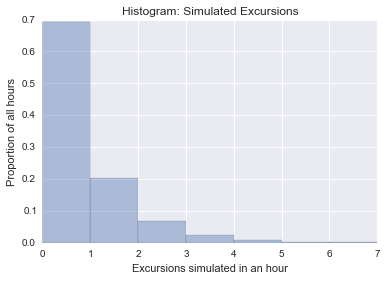

In [23]:
sns.distplot(sim_excursions, kde = False, norm_hist= True, bins = sim_excursions.max())
plt.ylabel('Proportion of all hours')
plt.xlabel('Excursions simulated in an hour')
plt.title('Histogram: Simulated Excursions')
plt.show()

This histogram above looks similar to the one representing our distribution of real excursions. 
The binomial distribution with the ~0.25% probability seems to model the real data decently well until some of the more unusual values are found, which is why the x-scale doesn't go up to 40 like that of the real data.<br> 

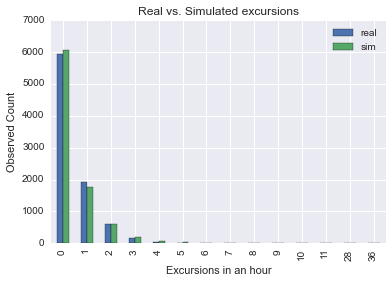

In [24]:
comparisons = pd.concat({'real' : binned, 'sim' : binned_sims}, axis = 1)
comparisons.plot(kind = 'bar')
plt.xlabel('Excursions in an hour')
plt.ylabel('Observed Count')
plt.title('Real vs. Simulated excursions')
plt.show()

Side-by-side comparison of the real vs. simulated excursion data which were used for the chart above:

N.B.: NaN simply means the simulated data did not have any observations with that count of excursions in the index. Of course, we see the 28 and 36 sticking out like sore thumbs, as they are highly improbable events under the given assumptions. This particular simulation generates no hour with excursions > 7. 

In [25]:
print comparisons

    real   sim
0   5950  6069
1   1936  1775
2    617   593
3    174   208
4     48    66
5     16    35
6     10     8
7      2     6
8      1   NaN
9      2   NaN
10     1   NaN
11     1   NaN
28     1   NaN
36     1   NaN


This was only one simulation, and we can't necessarily say that it alone will discredit the plusability of the outliers. But what about 1 simulation for every year BART has been in operation? The maximum observation of excursions in any one hour for each of those years is generally in the 7 - 10 range. 

In [26]:
print [scs.binom(n = all_by_hr, p = p_excursion).rvs().max() for _ in xrange(1972, 2016)]    

[9, 8, 8, 8, 9, 7, 7, 9, 8, 8, 8, 7, 8, 9, 9, 9, 7, 10, 8, 10, 9, 7, 8, 7, 7, 8, 8, 9, 8, 8, 6, 8, 10, 8, 7, 8, 8, 8, 7, 8, 9, 8, 7, 8]


In summary, the binomial distribution is appropriate for modeling the vast majority of the excursion data, assuming the probability of an excursion given entry at WOAK station is ~0.25%.. However, based on that, some of the data seem impossible, such as 36 excursions in a single hour of 2011. 

# Looking for answers

I will set out to look for answers to why hours may occur in which a significant amount of BART users incur an Excursion Fee in the next segment of the project. For now here are a couple motivating findings:

There's no explanation given by the relationship between excursions vs. the amount of other trips taken that hour. One might guess if more excursions occurred in an hour, it's probable that there were a lot of trips happening that hour as well. Just such a positive correlation is implied in the the simulation data on the left. However, the real data on the right tells a different, more interesting story.

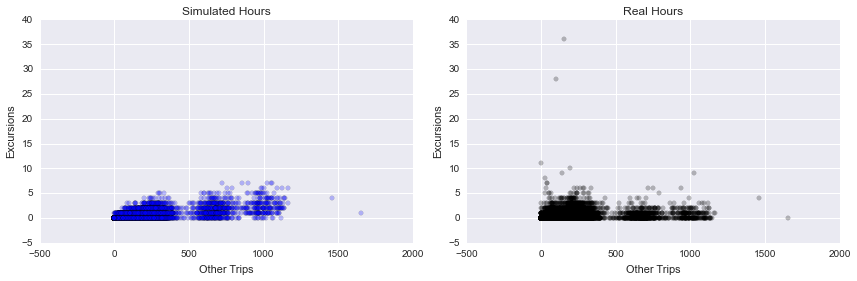

In [28]:
other_trips = woak_df.drop('WOAK', axis = 1).sum(axis = 1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1) 
plt.scatter(x = other_trips, y = sim_excursions, alpha = .25, c = 'b')
plt.ylim((-5, 40))
plt.ylabel('Excursions'), plt.xlabel('Other Trips'), plt.title('Simulated Hours')
plt.subplot(1,2,2)
plt.scatter(x = other_trips.values, y = excursions.values, alpha = .25, c = 'k')
plt.ylabel('Excursions'), plt.xlabel('Other Trips'), plt.title('Real Hours')
plt.tight_layout()

*** (teaser for next time: WHY ARE THERE 3 CLUMPS?) ***

I've also started exploring the most unusual observations of excursions to get hints as to where to look for patterns. They are summarized in the table below. 

N.B.: **excur**, **prob**, and **tot** refer to:<br>
the # of excursions, the probability of that observation, and the total number of trips that occurred during that hour (excursion inclusive), respectively.

In [29]:
sfs = scs.binom(n = all_by_hr, p = p_excursion).sf(excursions) 
pmfs = scs.binom(n = all_by_hr, p = p_excursion).pmf(excursions) 
probs = sfs + pmfs
# series of probabilities of observed # excursions or greater
probs = pd.Series(probs, index = excursions.index)
excur_probs = pd.concat({'tot' : all_by_hr, 'excur' : excursions, 'prob' : probs}, axis = 1)
# Bonferroni Adjustment
bonf_sig = excur_probs['prob'] < .05/len(excur_probs)
excur_probs[bonf_sig]

,excur,prob,tot
2011-01-01 02:00,7,4.538872e-11,49
2011-01-16 23:00,6,6.016775e-10,38
2011-02-09 23:00,7,2.846647e-11,46
2011-02-18 17:00,10,1.496189e-10,203
2011-02-18 18:00,28,9.374841e-46,127
2011-03-12 05:00,3,1.527415e-08,3
2011-03-14 04:00,11,1.703307e-27,13
2011-05-29 22:00,5,4.583694e-07,60
2011-08-08 20:00,5,1.790681e-08,32
2011-09-12 22:00,5,9.950376e-07,70


### If you have any feedback, even if you are not interested in data science or math, I would love to hear it!<br>I am interested in ideas especially with regard to what these unusual events may represent. If you are a BART user, worker, or have looked at/worked with this data as well, please do share your perspective! Thanks.

Want to see more data, more years, more stations? That's coming too.